# Modeling and Simulation in Python

Experiments with different ODE solvers

Copyright 2019 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [15]:
init = State(y = 2)
system = System(init=init, t_0=1, t_end=3)

,values
init,y 2 dtype: int64
t_0,1
t_end,3


In [16]:
def slope_func(state, t, system):
    [y] = state
    dydt = y + t
    return [dydt]

In [17]:
results, details = run_euler(system, slope_func)

In [18]:
get_last_value(results.y)

24.973714732487576

### Glucose minimal model

Read the data.

In [2]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time');

Interpolate the insulin data.

In [3]:
I = interpolate(data.insulin)

Initialize the parameters

In [4]:
G0 = 290
k1 = 0.03
k2 = 0.02
k3 = 1e-05

1e-05

To estimate basal levels, we'll use the concentrations at `t=0`.

In [5]:
Gb = data.glucose[0]
Ib = data.insulin[0]

11

Create the initial condtions.

In [6]:
init = State(G=G0, X=0)

,values
G,290
X,0


Make the `System` object.

In [7]:
t_0 = get_first_label(data)
t_end = get_last_label(data)

182

In [8]:
system = System(G0=G0, k1=k1, k2=k2, k3=k3,
                init=init, Gb=Gb, Ib=Ib, I=I,
                t_0=t_0, t_end=t_end, dt=2)

,values
G0,290
k1,0.03
k2,0.02
k3,1e-05
init,G 290 X 0 dtype: int64
Gb,92
Ib,11
I,<scipy.interpolate.interpolate.interp1d object...
t_0,0
t_end,182


In [9]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    k1, k2, k3 = system.k1, system.k2, system.k3 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [10]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [11]:
%time results = run_simulation(system, update_func);

CPU times: user 166 ms, sys: 4.08 ms, total: 170 ms
Wall time: 167 ms


In [12]:
results

,G,X
0,290,0
2,278.12,0
4,266.953,0.0003
6,256.295,0.002668
8,245.07,0.00404128
10,233.905,0.00467963
12,223.202,0.00525244
14,212.985,0.00572235
16,203.288,0.00609345
18,194.133,0.00632971


### Numerical solution

In the previous chapter, we approximated the differential equations with difference equations, and solved them using `run_simulation`.

In this chapter, we solve the differential equation numerically using `run_euler`...

Instead of an update function, we provide a slope function that evaluates the right-hand side of the differential equations.  We don't have to do the update part; the solver does it for us.

In [13]:
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivatives of G and X
    """
    G, X = state
    k1, k2, k3 = system.k1, system.k2, system.k3 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

We can test the slope function with the initial conditions.

In [14]:
slope_func(init, 0, system)

(-5.9399999999999995, 0.0)

Here's how we run the ODE solver.

In [15]:
system = System(G0=G0, k1=k1, k2=k2, k3=k3,
                init=init, Gb=Gb, Ib=Ib, I=I,
                t_0=t_0, t_end=t_end, dt=1)

%time results2, details = run_euler(system, slope_func)

CPU times: user 276 ms, sys: 368 µs, total: 277 ms
Wall time: 274 ms


`results` is a `TimeFrame` with one row for each time step and one column for each state variable:

In [16]:
results2

,G,X
0,290,0
1,284.06,0
2,278.298,7.5e-05
3,272.688,0.0002235
4,267.207,0.00088903
5,261.713,0.00206125
6,256.082,0.00298502
7,250.395,0.00366532
8,244.726,0.00416202
9,239.125,0.00447878


Plotting the results from `run_simulation` and `run_euler`, we can see that they are not very different.

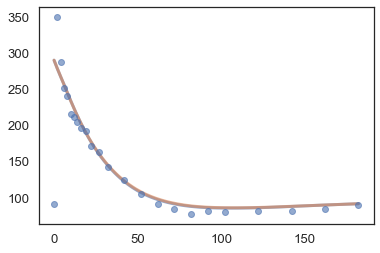

In [17]:
plot(results.G, '-')
plot(results2.G, '-')
plot(data.glucose, 'bo')

The differences in `G` are less than 1%.

In [18]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100

max(abs(percent_diff.dropna()))

0.970403647921524

### Dropping pennies

I'll start by getting the units we need from Pint.

In [19]:
m = UNITS.meter
s = UNITS.second

<Unit('second')>

And defining the initial state.

In [20]:
init = State(y=381 * m, 
             v=0 * m/s)

,values
y,381 meter
v,0.0 meter / second


Acceleration due to gravity is about 9.8 m / s$^2$.

In [21]:
g = 9.8 * m/s**2

9.8 <Unit('meter / second ** 2')>

When we call `odeint`, we need an array of timestamps where we want to compute the solution.

I'll start with a duration of 10 seconds.

In [22]:
t_end = 10 * s

10 <Unit('second')>

Now we make a `System` object.

In [23]:
system = System(init=init, g=g, t_end=t_end)

,values
init,y 381 meter v 0.0 meter / secon...
g,9.8 meter / second ** 2
t_end,10 second


And define the slope function.

In [24]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, v = state
    g = system.g    

    dydt = v
    dvdt = -g
    
    return dydt, dvdt

It's always a good idea to test the slope function with the initial conditions.

In [25]:
dydt, dvdt = slope_func(system.init, 0, system)
print(dydt)
print(dvdt)

0.0 meter / second
-9.8 meter / second ** 2


Now we're ready to call `run_euler`

In [26]:
system.set(dt=0.1*s)
results, details = run_euler(system, slope_func, max_step=0.5)
details.message

'Success'

In [27]:
results

,y,v
0.0,381 meter,0.0 meter / second
0.1,381.0 meter,-0.9800000000000001 meter / second
0.2,380.902 meter,-1.9600000000000002 meter / second
0.3,380.70599999999996 meter,-2.9400000000000004 meter / second
0.4,380.412 meter,-3.9200000000000004 meter / second
0.5,380.02 meter,-4.9 meter / second
0.6,379.53 meter,-5.880000000000001 meter / second
0.7,378.94199999999995 meter,-6.860000000000001 meter / second
0.8,378.256 meter,-7.840000000000002 meter / second
0.9,377.472 meter,-8.820000000000002 meter / second


In [28]:
def crossings(series, value):
    """Find the labels where the series passes through value.

    The labels in series must be increasing numerical values.

    series: Series
    value: number

    returns: sequence of labels
    """
    units = get_units(series.values[0])
    values = magnitudes(series - value)
    interp = InterpolatedUnivariateSpline(series.index, values)
    return interp.roots()

In [29]:
t_crossings = crossings(results.y, 0)

array([8.86802711])

In [30]:
system.set(dt=0.1*s)
results, details = run_ralston(system, slope_func, max_step=0.5)
details.message

'Success'

In [31]:
t_crossings = crossings(results.y, 0)

array([8.81788535])

Here are the results:

In [32]:
results

,y,v
0.0,381 meter,0.0 meter / second
0.1,380.951 meter,-0.9800000000000001 meter / second
0.2,380.80400000000003 meter,-1.9600000000000002 meter / second
0.3,380.559 meter,-2.9400000000000004 meter / second
0.4,380.216 meter,-3.9200000000000004 meter / second
0.5,379.77500000000003 meter,-4.9 meter / second
0.6,379.23600000000005 meter,-5.880000000000001 meter / second
0.7,378.59900000000005 meter,-6.860000000000001 meter / second
0.8,377.86400000000003 meter,-7.840000000000002 meter / second
0.9,377.031 meter,-8.820000000000002 meter / second


And here's position as a function of time:

Saving figure to file figs/chap09-fig01.pdf


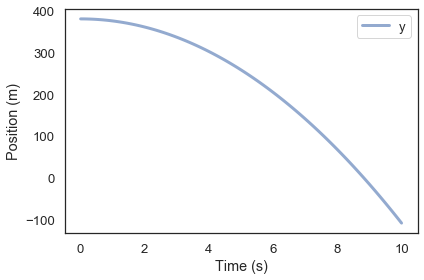

In [33]:
def plot_position(results):
    plot(results.y, label='y')
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

plot_position(results)
savefig('figs/chap09-fig01.pdf')

### Onto the sidewalk

To figure out when the penny hit the sidewalk, we can use `crossings`, which finds the times where a `Series` passes through a given value.

In [34]:
def crossings(series, value):
    """Find the labels where the series passes through value.

    The labels in series must be increasing numerical values.

    series: Series
    value: number

    returns: sequence of labels
    """
    units = get_units(series.values[0])
    values = magnitudes(series - value)
    interp = InterpolatedUnivariateSpline(series.index, values)
    return interp.roots()

In [35]:
t_crossings = crossings(results.y, 0)

array([8.81788535])

For this example there should be just one crossing, the time when the penny hits the sidewalk.

In [36]:
t_sidewalk = t_crossings[0] * s

8.81788534972054 <Unit('second')>

We can compare that to the exact result.  Without air resistance, we have

$v = -g t$

and

$y = 381 - g t^2 / 2$

Setting $y=0$ and solving for $t$ yields

$t = \sqrt{\frac{2 y_{init}}{g}}$

In [37]:
sqrt(2 * init.y / g)

8.817885349720552 <Unit('second')>

The estimate is accurate to about 10 decimal places.

## Events

Instead of running the simulation until the penny goes through the sidewalk, it would be better to detect the point where the penny hits the sidewalk and stop.  `run_ralston` provides exactly the tool we need, **event functions**.

Here's an event function that returns the height of the penny above the sidewalk:

In [38]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And here's how we pass it to `run_ralston`.  The solver should run until the event function returns 0, and then terminate.

In [39]:
results, details = run_ralston(system, slope_func, events=event_func)
details

,values
message,Success


The message from the solver indicates the solver stopped because the event we wanted to detect happened.

Here are the results:

In [40]:
results

,y,v
0.000000,381 meter,0.0 meter / second
0.100000,380.951 meter,-0.9800000000000001 meter / second
0.200000,380.80400000000003 meter,-1.9600000000000002 meter / second
0.300000,380.559 meter,-2.9400000000000004 meter / second
0.400000,380.216 meter,-3.9200000000000004 meter / second
0.500000,379.77500000000003 meter,-4.9 meter / second
0.600000,379.23600000000005 meter,-5.880000000000001 meter / second
0.700000,378.59900000000005 meter,-6.860000000000001 meter / second
0.800000,377.86400000000003 meter,-7.840000000000002 meter / second
0.900000,377.031 meter,-8.820000000000002 meter / second


With the `events` option, the solver returns the actual time steps it computed, which are not necessarily equally spaced. 

The last time step is when the event occurred:

In [41]:
t_sidewalk = get_last_label(results) * s

8.81780237518735 <Unit('second')>

The result is accurate to about 15 decimal places.

We can also check the velocity of the penny when it hits the sidewalk:

In [42]:
v_sidewalk = get_last_value(results.v)

-86.41446327683617 <Unit('meter / second')>

And convert to kilometers per hour.

In [43]:
km = UNITS.kilometer
h = UNITS.hour
v_sidewalk.to(km / h)

-311.09206779661025 <Unit('kilometer / hour')>

If there were no air resistance, the penny would hit the sidewalk (or someone's head) at more than 300 km/h.

So it's a good thing there is air resistance.